  # Planth Pathology Detection

> Identify the category of foliar diseases in apple trees [Kaggle competition URL](https://www.kaggle.com/c/plant-pathology-2020-fgvc7)

  ![Heading](https://storage.googleapis.com/kaggle-competitions/kaggle/18648/logos/header.png?t=2020-02-20-17-30-35)




1. **Import needed packages**
2. **Prepare/Showcase dataset**
  *   Load dataset
  *   EDA

3. **Fast.ai v1**
  *   Baseline model with TL
  *   With Augmentation, LR improvments
  *   Bigger model with Resnet 50



4. **Pytorch Implementation**
  * Data prep
  * Model architecture
  * Baseline model
    * Transfer learning
  * Hyperparm tuninig/transforms
    * Augmentation etc

5. **Submit to Kaggle**
  * Standings?


6. **Tensorflow Implementation** (optional)
  * Try tensorflow 

7. **FastAi v2** (optional)
 * Try v2










In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib as plt
import seaborn as sns
from fastai.vision import *

In [ ]:
path = Path('/content/drive/My Drive/data/plant_pathology/')

In [ ]:
df = pd.read_csv(path/'train.csv')
df.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


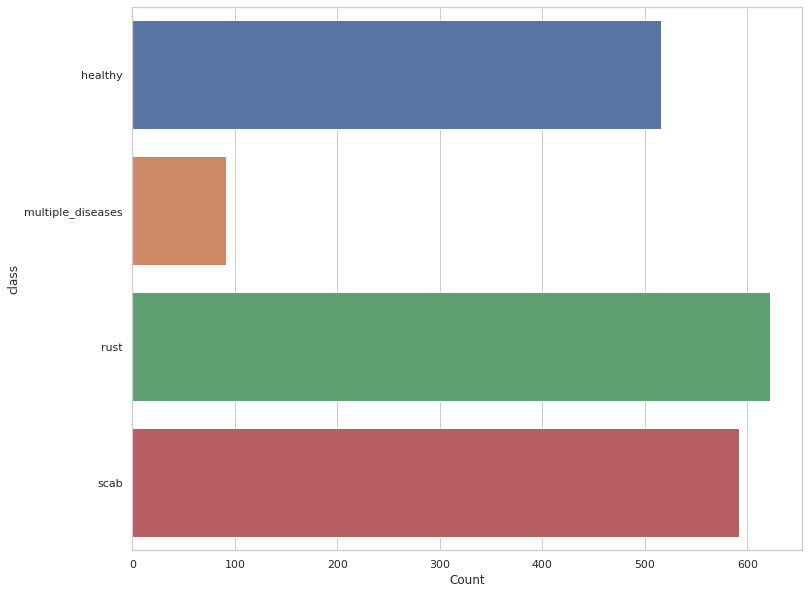

In [ ]:
# Create Class count dataframe
class_count = pd.DataFrame(df.sum(axis=0)).reset_index()
class_count.columns = ['class', 'Count']
class_count.drop(class_count.index[0], inplace=True)

# Visualize class distribution as Barchartfig, 
sns.set(style="whitegrid")
plt.subplots(figsize=(12,10))
sns.barplot(y="class", x="Count",  data=class_count);

In [ ]:
#Dataframe preprocessing
df = pd.read_csv(path/'train.csv')

def replace_value(row):
   for c in df.columns:
     if row[c]==1:
       return c

def add_jpg(row):
  return row['image_id']+'.jpg'


df['label'] = df.apply(replace_value, axis=1)
df = df[['image_id','label']]
df["encoded_label"] = df["label"].astype('category').cat.codes
df['image_url'] = df.apply(add_jpg, axis=1)
df.head()

,image_id,label,encoded_label,image_url
0,Train_0,scab,3,Train_0.jpg
1,Train_1,multiple_diseases,1,Train_1.jpg
2,Train_2,healthy,0,Train_2.jpg
3,Train_3,rust,2,Train_3.jpg
4,Train_4,healthy,0,Train_4.jpg


In [ ]:
# Predictions
test_df = pd.read_csv(path/'test.csv')
test_df['image_id'] = 'images/' + test_df['image_id'] + '.jpg'
test_df.head()

test_data = ImageList.from_df(test_df, path)

In [ ]:
#transformations
tfms = get_transforms(do_flip = True,
                      flip_vert=True, 
                      max_lighting=0.1, 
                      max_zoom=1.05,
                      max_warp=0.,
                      max_rotate=15,
                      p_affine=0.75,
                      p_lighting=0.75) 

Explanation on arguments of get_transforms() function


*   **do_flip**: if True, a random flip is applied with probability 0.5
*   **flip_vert**: requires do_flip=True. If True, the image can be flipped vertically or rotated by 90 degrees, otherwise only an horizontal flip is applied
* **max_rotate**: if not None, a random rotation between -max_rotate and max_rotate degrees is applied with probability p_affine
* **max_zoom**: if not 1. or less, a random zoom between 1. and max_zoom is applied with probability p_affine
* **max_lighting**: if not None, a random lightning and contrast change controlled by max_lighting is applied with probability p_lighting
* **max_warp**: if not None, a random symmetric warp of magnitude between -max_warp and maw_warp is applied with probability p_affine
* **p_affine**: the probability that each affine transform and symmetric warp is applied
* **p_lighting**: the probability that each lighting transform is applied
xtra_tfms: a list of additional transforms you would like to be applied

In [ ]:
#data = ImageDataBunch.from_folder(path, ds_tfms=tfms, valid='valid', size=224, bs=64 ).normalize(imagenet_stats)

In [ ]:
src = (ImageImageList.from_csv(path,'train.csv', folder='images', suffix='.jpg')
              .split_by_rand_pct(0.2)
              .label_from_df(cols=[1,2,3,4])
              .add_test(test_data))

In [ ]:
train_data = (src
              .transform(tfms, size=(64,64))
              .databunch()
              .normalize(imagenet_stats))

In [ ]:
train_data.classes, train_data.c, len(train_data.train_ds),len(train_data.valid_ds)

([1, 2, 3, 4], 4, 1457, 364)

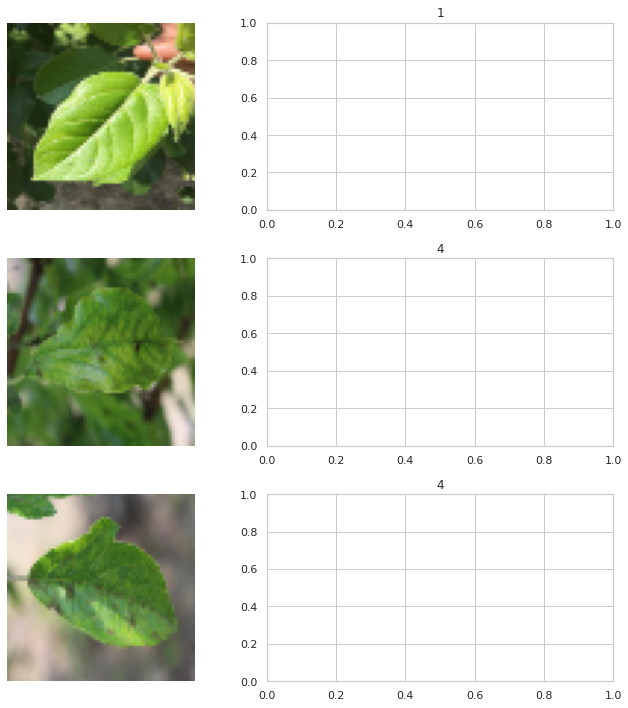

In [ ]:
train_data.show_batch(rows=3, figsize=(10,10))

In [ ]:
learn = cnn_learner(train_data, models.resnet50, metrics=[accuracy,fbeta]) 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.31E-02
Min loss divided by 10: 1.45E-02


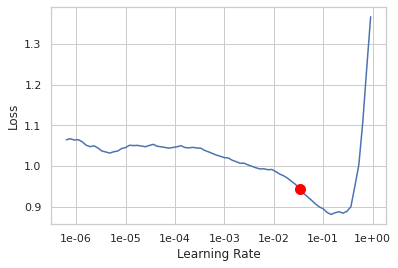

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(30, max_lr=slice(1e-01, 1e-02))

epoch,train_loss,valid_loss,accuracy,fbeta,time
0,0.970350,0.725749,0.241758,0.631574,02:31
1,0.862303,0.733110,0.328984,0.610168,00:54
2,0.783808,0.881061,0.331044,0.642040,00:54
3,0.658946,0.562851,0.208104,0.687369,00:54
4,0.550332,0.688977,0.103022,0.593080,00:54
5,0.474908,0.484868,0.432692,0.694990,00:54
6,0.426310,0.364009,0.121566,0.758700,00:54
7,0.379973,0.312034,0.241071,0.798012,00:54
8,0.353494,0.310167,0.234890,0.809720,00:54
9,0.331942,0.523304,0.375000,0.741039,00:54


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-06
Min loss divided by 10: 6.31E-08


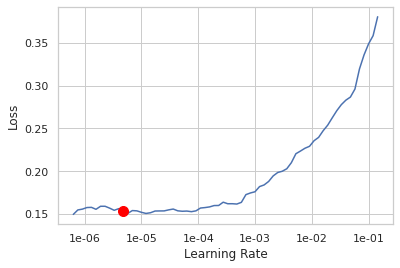

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(30, max_lr=slice(1e-06,1e-05))

epoch,train_loss,valid_loss,accuracy,fbeta,time
0,0.153557,0.169084,0.236264,0.890502,00:53
1,0.159753,0.169331,0.234890,0.891091,00:53
2,0.157983,0.168225,0.234203,0.892465,00:53
3,0.153803,0.168461,0.236951,0.892465,00:53
4,0.154753,0.166961,0.234890,0.895801,00:53
5,0.158194,0.167453,0.236951,0.895997,00:53
6,0.158798,0.168068,0.238324,0.886512,00:53
7,0.155938,0.167819,0.239011,0.889848,00:54
8,0.154555,0.168696,0.240385,0.889521,00:53
9,0.153917,0.165979,0.232830,0.890764,00:53


### Submission with Fastai V1

In [ ]:
preds, y = learn.get_preds(DatasetType.Test)

In [ ]:
sample_df = pd.read_csv(path/'sample_submission.csv')
sample_df.iloc[:,1:] = preds.numpy()
sample_df.to_csv(path/'submission_Resnet50_fastai.csv', index=False)
#Score 89.11%